In [1]:
%%writefile readhtml.py
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from urllib.parse import urlparse

# Method takes a webpage url,
# and returns an array of strings:
# [filetype, title, metadata, body, link0, link1, link2, link3]
# metadata is seperated in key/value by "="
# tag content and links are separated by space

def readhtml(url: str) -> [str]:
    
    try:
        print(f'Trying url: {url}')
        data = requests.get(url)
    except Exception as err:
        print(err)
        return None;
        
    html = BeautifulSoup(data.text, "html.parser")
    if html == None:
        return html;
    
    head = html.head != None
    title = ''
    metadata = ''
        
    domain = urlparse(url).netloc
        
    if head:
        title_tag = html.head.find('title')
        title = title_tag.string if title_tag != None else np.nan
        
        for meta in html.head.find_all('meta'):
            for key in meta.attrs.keys():
                metadata += f'{key}={meta[key]} '
    else:
        title = np.nan
        meta = np.nan
        
    links = []
    content = ''
    if html.body != None:
        for a_tag in html.body.find_all('a'):
            link = a_tag.get('href')
            if link is None:
                continue;
            if link.startswith('http://') or link.startswith('https://'):
                if (len(links) > 3):
                    break;
                links.append(link)
            
        for elem in html.body.stripped_strings:
            content += elem + ' '
    links.extend([np.nan] * (4 - len(links)))
    
    return 'html', domain, title, content, metadata, *links

# takes an array of start urls, and integer representing the depth of the search
# calls readhtml recursively and blacklists bad responses, and already visited pages
# returns a pandas dataframe

def readhtml_recursively(start_urls: [str], max_depth: int):
    
    df = pd.DataFrame(columns = ['filetype', 'domain', 'title', 'content', 'meta', 'link0', 'link1', 'link2', 'link3', 'level'])
    urls_to_read = start_urls
    black_list = []
    
    for iteration in range(max_depth):
        for url in urls_to_read:
            result = readhtml(url)
            if result != None:
                df.loc[len(df.index)] = [*result, iteration]
            else:
                black_list.append(url)
            

        links0 = df['link0'].to_list()
        links1 = df['link1'].to_list()
        links2 = df['link2'].to_list()
        links3 = df['link3'].to_list()

        links_total = [*links0, *links1, *links2, *links3]
        
        urls_to_read.clear()
        for link in links_total:
            if isinstance(link, str) and link not in black_list:
                urls_to_read.append(link)
                black_list.append(link)
    
    return df;

Overwriting readhtml.py


## Test. Get data from urls

In [30]:
# from readhtml import readhtml
import pandas as pd

# file_type, meta, content = readhtml('https://example.com')

# df = pd.DataFrame(columns = ['filetype', 'title', 'content', 'meta', 'link0', 'link1', 'link2', 'link3'])

url_arr = ['https://id.ku.dk'
    'https://google.com',
          'https://example.com',
           'https://theguardian.com',
#          'https://dr.dk',
#          'https://cphbusiness.dk',
#           'https://aljazeera.com'
          ]

df = readhtml_recursively(url_arr, 5)
df

Trying url: https://id.ku.dkhttps://google.com
HTTPSConnectionPool(host='id.ku.dkhttps', port=443): Max retries exceeded with url: //google.com (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x788f81f2c5d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Trying url: https://example.com
Trying url: https://theguardian.com
Trying url: https://www.iana.org/domains/example
Trying url: https://support.theguardian.com/subscribe/weekly?REFPVID=&INTCMP=undefined&acquisitionData=%7B%22source%22%3A%22GUARDIAN_WEB%22%2C%22componentId%22%3A%22PrintSubscriptionsHeaderLink%22%2C%22componentType%22%3A%22ACQUISITIONS_HEADER%22%2C%22referrerPageviewId%22%3A%22%22%2C%22referrerUrl%22%3A%22%22%7D
Trying url: https://profile.theguardian.com/signin?INTCMP=DOTCOM_NEWHEADER_SIGNIN&ABCMP=ab-sign-in&componentEventParams=componentType%3Didentityauthentication%26componentId%3Dguardian_signin_header
Trying url: https://jobs.theguardian.com
Trying url: h

,filetype,domain,title,content,meta,link0,link1,link2,link3,level
0,html,example.com,Example Domain,Example Domain This domain is for use in illus...,charset=utf-8 http-equiv=Content-type content=...,https://www.iana.org/domains/example,NaN,NaN,NaN,0
1,html,theguardian.com,"News, sport and opinion from the Guardian's Eu...",Skip to main content Skip to navigation Print ...,"name=description content=Latest Europe news, c...",https://support.theguardian.com/subscribe/week...,https://profile.theguardian.com/signin?INTCMP=...,https://jobs.theguardian.com,https://www.google.co.uk/advanced_search?q=sit...,0
2,html,www.iana.org,Example Domains,Domains Protocols Numbers About Example Domain...,charset=utf-8 http-equiv=Content-type content=...,http://pti.icann.org,http://www.icann.org/,https://www.icann.org/privacy/policy,https://www.icann.org/privacy/tos,1
3,html,support.theguardian.com,The Guardian Weekly Subscriptions | The Guardian,Please enable JavaScript - we use it to provid...,charset=UTF-8 name=viewport content=width=devi...,https://www.enable-javascript.com/,NaN,NaN,NaN,1
4,html,profile.theguardian.com,Sign in | The Guardian,The Guardian - Back to home The Guardian Sign ...,charset=utf-8 name=viewport content=width=devi...,https://www.theguardian.com,https://www.theguardian.com/help/terms-of-service,https://www.theguardian.com/help/privacy-policy,https://policies.google.com/privacy,1
...,...,...,...,...,...,...,...,...,...,...
78,html,www.youtube.com,YouTube,Om Presse Ophavsret Kontakt os Youtubere Annon...,http-equiv=X-UA-Compatible content=IE=edge htt...,https://www.youtube.com/about/,https://www.youtube.com/about/press/,https://www.youtube.com/about/copyright/,https://www.youtube.com/creators/,4
79,html,www.guardianjobsrecruiter.co.uk,\r\n\tGuardian Jobs | Recruiter Services\r\n,Skip to main content Skip to secondary menu Re...,charset=utf-8 http-equiv=X-UA-Compatible conte...,https://jobs.theguardian.com/,https://jobs.theguardian.com/logon/,https://jobs.theguardian.com/,https://recruiters.theguardian.com/,4
80,html,blog.google,New ways to make more sustainable choices,Skip to main content The Keyword New ways to m...,charset=utf-8 http-equiv=X-UA-Compatible conte...,https://twitter.com/intent/tweet?text=New%20wa...,https://www.facebook.com/sharer/sharer.php?cap...,https://www.linkedin.com/shareArticle?mini=tru...,https://cloud.google.com/blog/,4
81,html,subscribe.icann.org,Content Subscription,Logo en Search Search Search Filtered Search L...,charset=utf-8 name=viewport content=width=devi...,https://www.icann.org/en,http://subscribe.icann.org,http://subscribe.icann.org,http://account.icann.org/logout?app_id=undefined,4


In [4]:
df['title']

0                                                 Google
1                                         Example Domain
2      News, sport and opinion from the Guardian's Eu...
3                   DR | Nyheder - Breaking - TV - Radio
4      Cphbusiness - Erhvervsakademiet Copenhagen Bus...
                             ...                        
181         \r\n\tGuardian Jobs | Recruiter Services\r\n
182            New ways to make more sustainable choices
183                                 Content Subscription
184              Safeguarding your data - Analytics Help
185                                              YouTube
Name: title, Length: 186, dtype: object

In [ ]:
df.isnull().sum()

In [6]:
df["domain"] = df["domain"].astype('category')

In [12]:
cat_data = df.select_dtypes(['category']).columns
cat_data

Index(['domain'], dtype='object')

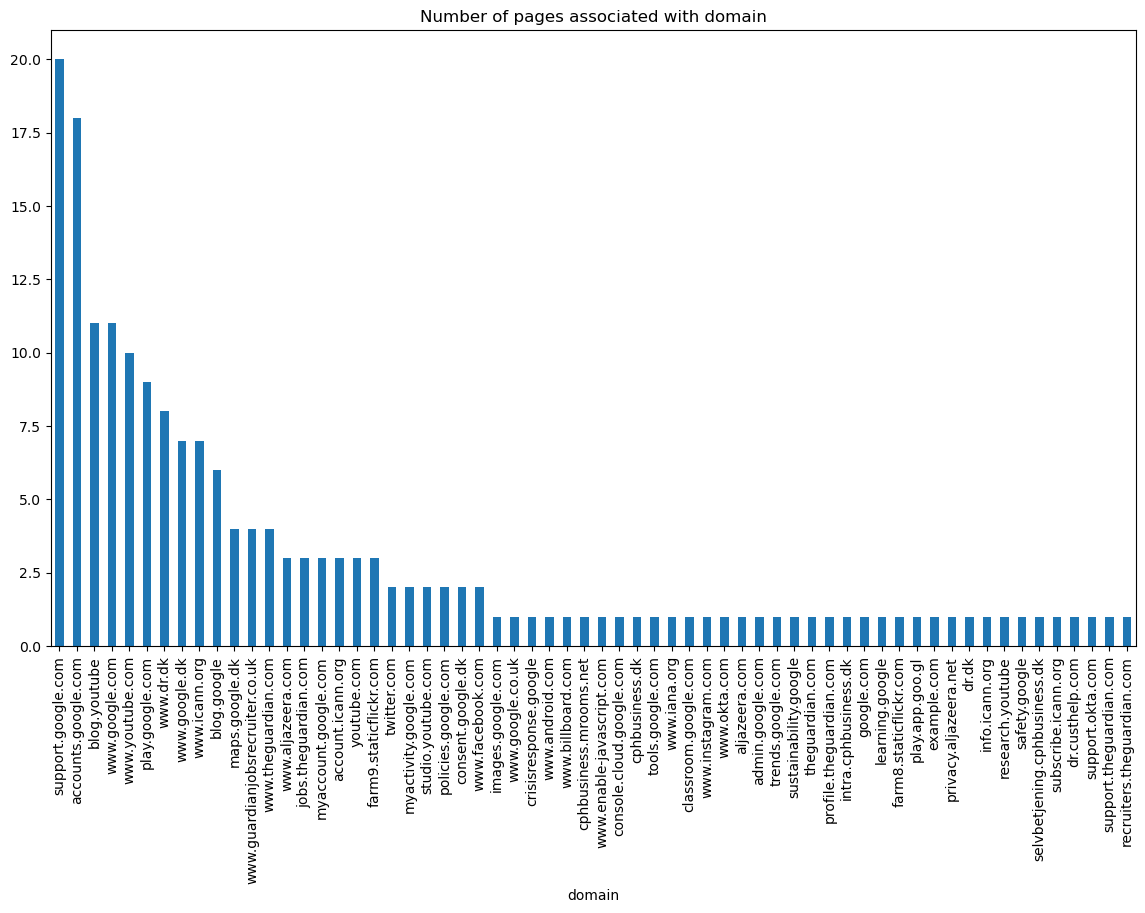

In [18]:
bar_chart = df['domain'].value_counts().plot(kind='bar',figsize=(14,8),
                                    title="Number of pages associated with domain")